# Question A1 (15 marks)

Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.3** to each of the hidden layers.

In [44]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

---

## 1. Define the model class

We need to define a Neural Network with
- Input Layer with 77 input neurons (since we have 77 features)
- 3 Hidden Layers with 128 neurons each and ReLU activation function
- Output Layer with 1 neuron and Sigmoid activation function

After each hidden layer, we need to apply Dropout with probability 0.3. </br>
For each batch (not epoch), it randomly choose a fraction of hiddeny layer neurons (30% in this case) and set their output to zero during the forward pass, no matter what their actual output value is. This forces the network to not rely too much on any particular neuron.

We use Sigmoid for the final layer (instead of Softmax) as it is a binary classification problem (pos vs neg), and we just need a single outpit neuron in the range [0,1] representing probability of positive class. </br>
Use Softmax only if we have multiple output neurons for multi-class classification

In [45]:
class MLP(nn.Module):

    def __init__(
            self                    , 
            num_features    = 128   , 
            num_hidden      = 256   , 
            num_labels      = 1     ,
        ):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(num_features, num_hidden),    # Creates a fully connected layer that performs U = W*X + B
            nn.ReLU(),                              # Apply ReLU activation function Y = f(U)
            nn.Dropout (0.3),                       # Apply Dropout with probability of 0.3

            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Dropout (0.3),

            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Dropout (0.3),

            nn.Linear(num_hidden, num_labels),
            nn.Sigmoid()                            
        )

    def forward(self, x):
        logits = self.mlp_stack(x)                 
        return logits

### ❗ Shape of Activation Function

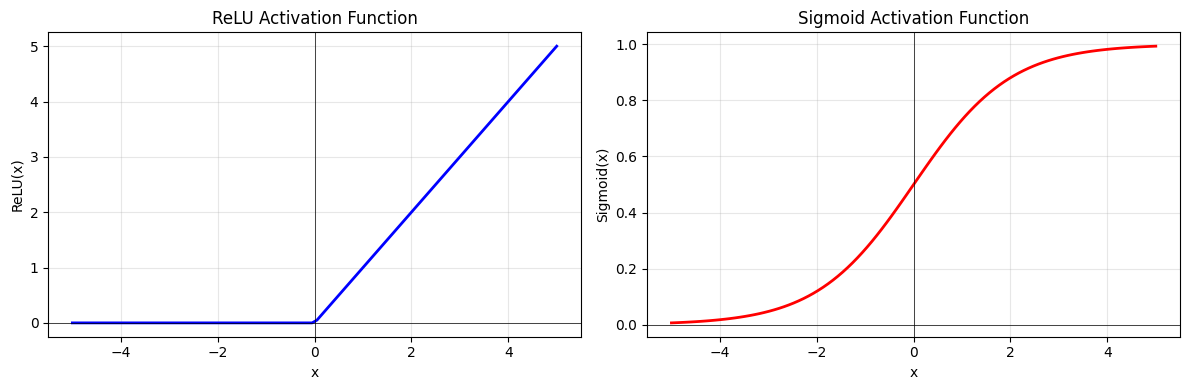

In [46]:
import numpy as np

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ReLU activation function
x = np.linspace(-5, 5, 100)
relu = np.maximum(0, x)

ax1.plot(x, relu, 'b-', linewidth=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('ReLU(x)')
ax1.set_title('ReLU Activation Function')
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

# Sigmoid activation function
sigmoid = 1 / (1 + np.exp(-x))

ax2.plot(x, sigmoid, 'r-', linewidth=2)
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('Sigmoid(x)')
ax2.set_title('Sigmoid Activation Function')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

ReLU: Rectified Linear Unit
- f(x) = max (0, x)
- Often used in hidden layers for faster training and avoiding vanishing gradients

Sigmoid 
- f(x) = 1 / (1 + e^(-x)) ∈ (0, 1)
- Used in output layer for binary classification, where outputs can be interpreted as probabilities

---

## 2. Split the dataset and do preprocessing

Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

The labels are in the 'Filename' column, which contains either 'pos' or 'neg'. We extract them out into a new column named 'label', where 'pos' is mapped to 1 and 'neg' is mapped to 0.

In [47]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(
        df              = df,
        columns_to_drop = ['filename', 'label'],    # Columns to drop for training set
        test_size       = 0.25,
        random_state    = 42
    )

    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

print ("Label distribution of the entire dataset:")
print (df['label'].value_counts())

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

Label distribution of the entire dataset:
label
pos    6202
neg    5855
Name: count, dtype: int64


In [48]:
# Check the distribution of labels in the training and testing sets
print("Label distribution in the training set:")
print(pd.Series(y_train).value_counts())

print("\nLabel distribution in the testing set:")
print (pd.Series(y_test).value_counts())

Label distribution in the training set:
1    4648
0    4394
Name: count, dtype: int64

Label distribution in the testing set:
1    1554
0    1461
Name: count, dtype: int64


### ❗ Stratified Splitting

Here the distribution of the 2 classes are roughly the same. But in the case that they are not, we can specify `stratify = y` in  `train_test_split` so that the class distribution of `y` is preserved in both train and test set.

---

## 3. Define a Pytorch Dataset and Dataloaders

Use the training dataset to train the model for 200 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.0005**, weight decay of **0.0005** and **batch size = 64**. Implement early stopping with patience of **5**.

### ❗ CustomDataset and DataLoader

While we can pass the original `X_train`, `y_train` tensors directly into the PyTouch NN model, for more complex data or simply large amount of data, `CustomDataset` and `DataLoader` is the standard practise to feed data into the NN in batches efficiently.

`CustomDataset`: Tells PyTouch how to read a single data point. Inherit from `torch.utils.data.Dataset`, and the following 3 methods need to be overwritten:
- `__init__`: pass the features and labels    
- `__len__`: so that PyTouch knows when an epoch has finished
- `__getitem__`: given an index, it retrieves a specific feature set and label


`DataLoader`: Handles batching and feeding data into the model.  

In [49]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    train_dataset   : CustomDataset = CustomDataset(X_train_scaled, y_train)
    test_dataset    : CustomDataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader: DataLoader    = DataLoader(
        dataset     = train_dataset, 
        batch_size  = 64,
        shuffle     = True  # Shuffle the training data at the beginning of each epoch
    )
    test_dataloader : DataLoader    = DataLoader(
        dataset     = test_dataset, 
        batch_size  = 64,
        shuffle     = False # No need to shuffle test data (Of course global metrics like MSE will be the same regardless, but good practise for consistency)
    )

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

### ❗ Choosing Batch Size

| Feature | Small Batch (e.g., 32) | Large Batch (e.g., 4096) |
|---|---|---|
| Updates per epoch | Many (10,000 items / 32 = 312 updates). The model learns "constantly" throughout the epoch. | Few (10,000 items / 4096 = ~2 updates). The model barely changes during an epoch. |
| Gradient quality | Noisy. The average of 32 items might not represent the whole dataset well. The path to the minimum is "jittery." | Stable. The average of 4096 items is a more accurate representation of the true gradient. |
| Generalization | Better. The noise helps the model "jump out" of bad solutions (sharp minima) and find robust ones. | Worse. It tends to get stuck in the nearest solution, even if it is a brittle one (sharp minima). |
| Hardware usage | Inefficient. Your GPU spends more time loading data than doing math. | Efficient. GPUs love big matrices; this maximizes parallel processing. |

The total time to converge against batch size is a U shape curve
 - If batch size is too small, the system overhead dominates the tiny calculation
 - If batch size is too large, we need more epochs and time to reach the same accuracy, as 1 batch of size 100 is only slightly better than 1 batch of size 10, but with a batch of size 10 it can have 10 updates

---

## 4. Define the model, optimizer and loss function

We instantiate the MLP model defined earlier with 77 input features, 128 neurons per hidden layer, and 1 output neuron.

We use Adam (Adaptive Moment Estimation) Optimizer, which defines the rules to update weights and bias after each batch. It is a robust optimizer that combines RMSprop (adaptive learning rate / annealing) and momentum.

Our loss function here is Binary Cross-Entropy, standard for classification.

In [50]:
# Model: 77 input features -> 128 hidden units -> 1 output
model = MLP(num_features=77, num_hidden=128, num_labels=1)

# Optimizer and loss for binary classification with sigmoid output
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr           = 0.0005,  # learning rate at the beginning of training (will be gradually reduced via annealing)
    weight_decay = 0.0005   # L2 regularization constant to penalize large weights and prevent overfitting
)
loss_fn = nn.BCELoss()

---

## 5. Train model for 200 epochs. Record down train and test accuracies. Implement early stopping.

### 5.1 Train Loop

In [51]:
def train_one_epoch(
        model       , 
        dataloader  , 
        loss_fn     , 
        optimizer
    ):
    """Train for one epoch and return average loss and accuracy"""
    model.train()  # Enable dropout

    total_loss      = 0     # Sum of losses (binary cross entropy) across all batches (one epoch)
    total_correct   = 0     # Total number of correct predictions across all batches (one epoch)
    
    size            = len(dataloader.dataset)     # Total number of input patterns
    num_batches     = len(dataloader)             # Number of batches
    
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        # Forward pass
        predictions = model(X_batch)
        loss        = loss_fn(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()                                   # Add the loss of the current batch to the total loss for the epoch

        predicted_labels = (predictions > 0.5).float()              # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        total_correct += (predicted_labels == y_batch).sum().item() # Count the number of correct predictions in the batch and add to total_correct
    
    avg_loss = total_loss / size
    accuracy = total_correct / size
    return avg_loss, accuracy

### 5.2 Test Loop

In [52]:
def evaluate(
        model       , 
        dataloader  , 
        loss_fn
    ):
    """Evaluate model and return average loss and accuracy"""
    model.eval()  # Disable dropout

    total_loss      = 0
    total_correct   = 0

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            predictions = model(X_batch)

            loss = loss_fn(predictions, y_batch)
            total_loss += loss.item()

            predicted_labels = (predictions > 0.5).float()
            total_correct += (predicted_labels == y_batch).sum().item()
    
    avg_loss = total_loss / size
    accuracy = total_correct / size
    return avg_loss, accuracy

### 5.3 Training and Evaluation

In [53]:
# Training loop with early stopping
num_epochs          = 200
patience            = 5             # Number of epochs to wait for improvement in test loss before stopping training
min_test_loss       = float('inf')  # Initialize best test loss to infinity so that any improvement will be detected
patience_counter    = 0             # Counter to track how many epochs have passed without improvement in test loss
best_epoch          = 0             # To track the epoch at which the best model was saved
best_model_state    = None          # To store the state of the best model (weights)
last_epoch          = 200           # To track the last epoch completed (for final metrics)

# Track metrics for plotting
train_losses        = []
test_losses         = []
train_accuracies    = []
test_accuracies     = []

print("Starting training...")
for epoch in range(num_epochs):

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_dataloader, loss_fn, optimizer)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_dataloader, loss_fn)
    
    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Early stopping check
    if test_loss < min_test_loss:  # If the test loss has improved (decreased) compared to the best test loss seen so far
        min_test_loss = test_loss
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best test loss: {min_test_loss:.4f}")
        print(f"Best epoch: {best_epoch}")
        # Restore best model
        model.load_state_dict(best_model_state)
        last_epoch = epoch + 1
        break

print("\nTraining completed!\n")

print (f"At final epoch ({last_epoch}):")
print (f"   Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
print (f"   Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

print (f"At best epoch ({best_epoch}):")
print (f"   Train Loss: {train_losses[best_epoch-1]:.4f}, Train Accuracy: {train_accuracies[best_epoch-1]:.4f}")
print (f"   Test Loss: {test_losses[best_epoch-1]:.4f}, Test Accuracy: {test_accuracies[best_epoch-1]:.4f}")


Starting training...
Epoch [10/200] - Train Loss: 0.0094, Train Acc: 0.6789 | Test Loss: 0.0096, Test Acc: 0.6779
Epoch [20/200] - Train Loss: 0.0081, Train Acc: 0.7464 | Test Loss: 0.0088, Test Acc: 0.7151
Epoch [30/200] - Train Loss: 0.0072, Train Acc: 0.7794 | Test Loss: 0.0083, Test Acc: 0.7303
Epoch [40/200] - Train Loss: 0.0065, Train Acc: 0.8106 | Test Loss: 0.0079, Test Acc: 0.7489
Epoch [50/200] - Train Loss: 0.0059, Train Acc: 0.8308 | Test Loss: 0.0079, Test Acc: 0.7559

Early stopping triggered at epoch 51
Best test loss: 0.0078
Best epoch: 46

Training completed!

At final epoch (51):
   Train Loss: 0.0060, Train Accuracy: 0.8295
   Test Loss: 0.0078, Test Accuracy: 0.7609
At best epoch (46):
   Train Loss: 0.0061, Train Accuracy: 0.8228
   Test Loss: 0.0078, Test Accuracy: 0.7635


### 5.4 Visualization

Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


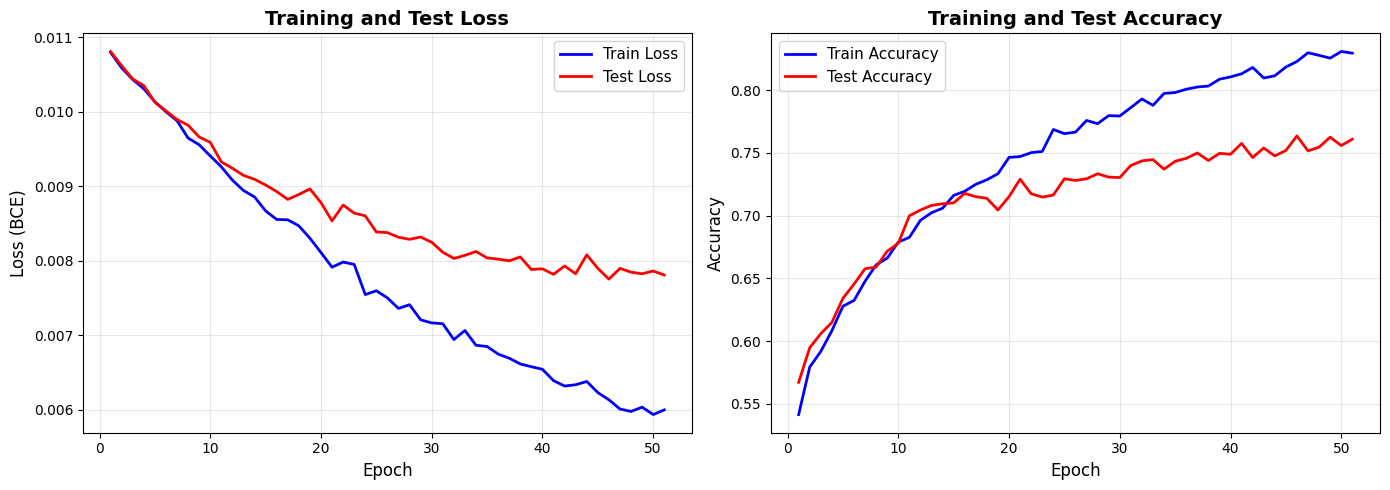

In [54]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (BCE)', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs_range, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. Comment on line plots.

**Loss Curves**

We can observe that although both training and test losses decrease rapidly in early epochs, the improvement start to differ at around epoch 10. Training Loss continues to decrease smoothly, whereas the decrease in test loss starts to slow down and plateauing, suggesting possible overfitting with more epochs. We overcome this by implementing early stopping, which triggered at epoch 51, suggesting that there is no improvement in test loss from epoch 46 onwards. Thus, we take the model at epoch 46 with the least test loss.

**Accuracy Curves**

A upside-down version of the Loss Curve. We can see that improvement in test accuracy starts to differ at around epoch 15, where it starts to slow down and plateau, suggesting possible overfitting. In fact, the gap between training and test accuracy indidcates the degree of overfitting, and we can see the gap widening with more epochs.